# Classification with Decision Trees

## Lecture plan

- **Tree-based methods**: building intuition.
   - The value of simple, interpretable methods. 
- Walking through a decision tree.
   - Entropy.  
   - Pruning.
- Using decision trees in Python with `sklearn`. 
- Additional considerations and trade-offs.

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Tree-based methods: building intuition

> In machine learning, **tree-based methods** involving *segmenting* the space of possible features $X$ into a number of simple "regions", which should maximally separate or predict our dependent variable (e.g., a class in classification).

- These *splitting rules* can be summarized in a **tree**.  
- Hence: "tree-based methods". 

The simplest approach is called a **decision tree**.

### So you want to make a *prediction*?

- Suppose you want to predict whether someone will choose to *write-off* their loan as a *loss*.  
   - Dependent variable: yes (`1`) vs. no (`0`).  
   - Independent variable: loan `amount`.
- A **decision tree** figures out the value of `amount` that *maximally separates* `1` vs. `0`.
   - Note: you can make multiple *splits* (recursively)!
- Intuitively: what is the value of `amount` that gives us the most **information** about `write-off`?
- Example:
   - `amount >= 50000`: less likely to be written off.
   - `amount < 50000`: more likely to be written off.

### An intutive example

<img src="img/trees_basics.png" width="500" alt="Decision tree example of loan write-off">


[Source](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8)

### Prediction via *stratification*

> With tree-based logic, we generate predictions by **recursively stratifying** our feature space.

Basic logic:

1. First, **stratify feature space** $X_1, ..., X_p$ into $J$ distinct *regions*, $R_1, ..., R_J$. 
2. Then, for each example in $R_j$, make the same *prediction*. 


Other considerations:
- Prediction for $R_j$ prediction is simply the *mean* response value for $Y$ in that region $R_j$.
- The goal is to choose regions $R_1, ..., R_J$ that provide the most **information** about our response variable $Y$.
   - "Most information" = biggest improvement over not knowing *anything* (i.e., our *priors*).

### The value of *interpretability*

- Decision trees are both *interpretable* and relatively *flexible*.  
   - This is a strength!
- Some have argued that they even mirror how *humans* conceptualize decisions.
   - E.g., [fast-and-frugal trees](https://en.wikipedia.org/wiki/Fast-and-frugal_trees) are specifically designed to be simple and humanlike.
- Sometimes, an intuitive approach is just as an important as making good predictions.

### ...but how do we find the splits?

- Decision trees work by **stratifying** our feature space into regions.  
- But how do we decide how and where to *split* that space?

## Decision trees: how they work

- The notion of "splitting" our data to make decisions makes sense.  
- But how do we decide:
   - Where to partition a given variable?
   - Which variables and partitions are most effective?  
   - How many partitions we should use?
- To explain this, we'll have to dive into the *math* behind decision trees.

### A working example

- To guide our discussion, we'll work with an example dataset.  
- We want to predict whether someone `Purchased (1 vs. 0)` an ad or not, based on several *features* about that person.

In [2]:
df_ads = pd.read_csv("data/classification/Social_Network_Ads.csv")
df_ads.head(2)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0


### Split for *maximum informativity*

- Intuitively, we want to **split** our feature space in *maximally informative ways*.  
- Which splits give us the **most information** about `Purchased`?
- Ideally, we'd want to compare:
   - Pre-split: how much uncertainty do we have about `Purchased`?
   - Post-split: how much *less* uncertainty do we have about `Purchased`?

We need a way to **quantify uncertainty** and compare it.

### Quantifying our uncertainty

We can *quantify our uncertainty* pre-split and post-split using two approaches:

1. Entropy.  
2. GINI Indix.

In each case, our measure allows us to compare our uncertainty *before splitting the data* to *after we split the data*.

Let's start by focusing on **entropy** and how it can help.

#### Entropy: a tool from information theory

> **Entropy** is a term from [information theory](https://en.wikipedia.org/wiki/Information_theory) that quantifies the amount of uncertainty in a distribution.

$\Large Entropy =-\sum _{k = 1}^K p(x_k)\log p(x_k)$

- $p(x_k)$: probability of observation $x_k$. 
- $log(p(x_k)$: log probability.  
- We *sum* up those products and invert the sign.

Let's look at some examples!

#### Understanding entropy

- Some rules of thumb:
   - Higher entropy = more uncertainty.  
   - Lower entropy = less uncertainty. 

In [3]:
### defining a function for entropy
def entropy(p):
    return -(p * np.log(p)).sum()

In [4]:
### Entropy of a 50/50 distribution
dist = np.array([.5, .5])
entropy(dist)

0.6931471805599453

#### Check-in

Try out some different probability distributions $[p_1, p_2]$ in the `entropy` function. Does have a more *uniform* distribution increase or decrease entropy?

In [5]:
### Your code here

#### More uniform distributions have more uncertainty

- Controlling for $k$ (the number of possible classes/events), a more *uniform* probability distribution has more uncertainty.  
- I.e., it's hard to know what you'll get before sampling from that distribution.

In [6]:
### Entropy of a 25/75 distribution
dist = np.array([.25, .75])
entropy(dist)

0.5623351446188083

In [7]:
### Entropy of a 10/90 distribution
dist = np.array([.1, .9])
entropy(dist)

0.3250829733914482

In [8]:
### Entropy of a 1/99 distribution
dist = np.array([.1, .99])
entropy(dist)

0.240208341794371

#### Check-in

Suppose we want to use entropy to help split our `Ads` data. Start by calculating the **entropy** over `Purchased` *pre-split*. If we split our data, do we want that value to go up or down?

In [9]:
### Your code here

#### The entropy of `Purchased`

- To calculate the entropy of `Purchased`, we first extract $p(k)$, the probability of each class.  
- We then calculate the `entropy` of this distribution.  
- Ideally, our splits should **decrease this entropy**. 

In [10]:
### Before we split the data...
dist = df_ads['Purchased'].value_counts() / len(df_ads)
dist.values

array([0.6425, 0.3575])

In [11]:
### Entropy pre-split
entropy(dist)

0.6519662072448864

#### Formalizing information gain

> **Information gain (IG)** is a measure of how much *information* a given split of our data gives us, i.e., how much it *reduces our uncertainty*.

$IG = Entropy(D) - \sum_{i=1}^k(\frac{|D_i|}{|D|} * Entropy(D_i))$

- $Entropy(D)$: The entropy *pre-split* of our dataset $D$.  
- $Entropy(D_i)$: The entropy for a given split/region of our dataset.
   - We calculate this measure for each region.
   - This is weighted by $\frac{|D_i|}{|D|}$, the fraction of our dataset corresponding to that split/region.

**Basic intuition**: IG should be *higher* when there's a larger difference——i.e., we get a larger average reduction in uncertainty.

#### Check-in: understanding IG

- Suppose our initial distribution of classes of $[.5, .5]$.  
- Then, suppose we draw one *split* of our data along a feature $X$.
   - In Region $R_1$, our distribution looks like: $[.25, .75]$
   - In Region $R_2$, our distribution looks like $[.75, .25]$. 

How would we calculate information gain? Was this a successful split?

In [12]:
### Your code here

#### IG: An illustrative example (1)

- First, calculate entropy of initial distribution.  
- Then, calculate entropy of each sub-region $R_1$ and $R_2$.  
- Subtract the average weighted entropy of $R_1$ and $R_2$ from initial entropy.

In [13]:
initial_entropy = entropy(np.array([.5, .5]))
initial_entropy

0.6931471805599453

In [14]:
r1_entropy = entropy(np.array([.75, .25]))
r2_entropy = entropy(np.array([.25, .75]))
print(r1_entropy)
print(r2_entropy)

0.5623351446188083
0.5623351446188083


#### IG: An illustrative example (2)

- Now, subtract the average weighted entropy of $R_1$ and $R_2$ from initial entropy.  
- What should we include? Was this a good split? 

In [15]:
ig = initial_entropy - ((.5*r1_entropy) + (.5*r2_entropy))
ig

0.130812035941137

#### Returning to `Ads`

- Before, we calculated the entropy over our distribution of `Purchased`.  
- Ideally, we'd make splits that *reduce* this entropy.  
- Such splits would result in **information gain**.

In [16]:
### Entropy over distribution
entropy((df_ads['Purchased'].value_counts() / len(df_ads)).values)

0.6519662072448864

### Interim summary: IG and decision trees

- With decision trees, we want to **split** our data in maximally informative ways.  
- We can measure this using **information gain**, which compares:
   - The **entropy** of our distribution over classes $k_1, ..., k_n$ *before* splitting the data. 
   - The **entropy** of our distribution over classes $k_1, ..., k_n$ *after* splitting the data (in each region).
- Better split = bigger reduction in entropy = bigger information gain!

### But how do we make our splits?

- It's computationally infeasible to consider *every possible split* of our data.  
- Instead, we use a **recursive, top-down, "greedy" approach**.  
  - `"Recursive"`: split one region into two, then each of those into two, and so on.
  - `"Top-down"`: start at the top of our tree.  
  - `"Greedy"`: at each step, make the *best* split, rather than looking ahead to make a better split. 

### Binary splitting, illustrated

This illustrates splitting a feature space into recursively smaller regions.

<img src="img/recursive_split.png" width="300" alt="Decision tree splitting into regions">

[Source](https://www.statlearning.com/)

### Binary splitting, illustrated

These splits can be represented as a **decision tree**.

<img src="img/tree_schematic.png" width="300" alt="Decision tree splitting into regions">

[Source](https://www.statlearning.com/)

### Complexity and pruning

- A "deep" tree (many splits) often results in **over-fitting**.  
- We need a way to **prune** the "branches" of this tree, i.e., get rid of the less useful splits.  
- One approach would be to simply stop splitting once improvements are marginal.
   - Problem: split $R_i$ may not be good, but split $R_{i+1}$ could be useful!
- Instead, we can grow a *large* tree, then *prune it back*.
   - A common way to do this is **cost complexity pruning**.

### Cost complexity pruning

> In **cost complexity pruning**, we consider a *subset* of all the possible trees, where each subset is penalized according to the size of the tree $|T|$.

- In addition to minimizing **error**, we add a penalty $\alpha$ for each subtree.  
- This parameter **tunes** the strictness of our penalty.
- Thus, where $R$ is the error rate, we want to minimize...

$$\Large R(T) + \alpha|T|$$

- Note: a **sub-tree** $T$ simply refers to everything below some node of the entire tree.

#### Check-in: Understanding pruning

In pruning our tree, we consider subtrees $T_1, T_2, ..., T_n$. We want to minimize the term:

$$R(T) + \alpha|T|$$

What is the impact of $\alpha$?

In [17]:
### Your answer here

#### The role of $\alpha$

- If $\alpha = 0$, we're not applying any *penalty*.  
- As $\alpha$ increases, we apply a **stricter penalty**.  
   - A stricter penalty *reduces the complexity* of the tree (i.e., fewer branches). 
- This is very similar conceptually to regularization in LASSO or Ridge regression!

### What about the Gini index?

- Decisions about **splitting** the data can be based either on *entropy* or the *Gini coefficient*.  
- Similar goals, but slightly different formulations.
The **Gini index** is defined as:

$$\Large G = \sum_{k = 1}^K p(k)* (1 - p(k))$$

- Again, $G$ will be smaller if most values $p(k)$ are close to either $0$ or $1$.

### Decision trees, summarized

- A **decision tree** aims to *recursively split* a dataset into *regions* that are maximally informative about a response variable $Y$.  
- Here, "maximally informative" can be defined (for classification) as changes in **entropy** or a **Gini index**.  
   - We want splits that *reduce* entropy (or the Gini index).  
- Large decision trees often **overfit**——we can reduce their complexity through *pruning*.  
   - In **cost complexity pruning**, we penalize subtrees as a function of their size (and ineffectiveness).

## Decision trees in practice

- Now that we understand decision trees at a high-level, let's apply them to our dataset!

In [18]:
### DecisionTreeClassifier is in sklearn.tree
from sklearn.tree import DecisionTreeClassifier

In [19]:
### Load in dataset again
df_ads = pd.read_csv("data/classification/Social_Network_Ads.csv")
df_ads.head(2)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0


### Understanding `DecisionTreeClassifier`

The `DecisionTreeClassifier` has a few important features:

- Like other `sklearn` classes, you can use `.fit` and `.predict`.  
- You can also determine:
   - `criterion` for **splitting**: `'gini'` vs. `'entropy`'
   - `max_depth`: how many layers of **recursive splitting** to allow?  
   - `ccp_alpha`: the $\alpha$ parameter to set for **cost complexity pruning** (default is 0).

### Using `DecisionTreeClassifier`

- To start, let's try to predict `Purchased` from `EstimatedSalary`.

In [20]:
### First, set up our features
X = df_ads[['EstimatedSalary']]
y = df_ads['Purchased']

In [21]:
### Then, initialize classifier
### We'll start with a very simple tree
clf = DecisionTreeClassifier(max_depth = 1, criterion = "entropy")

In [22]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

#### Visualizing our tree!

- The `plot_tree` function can be used to visualize our tree!  
- What can we learn from this?

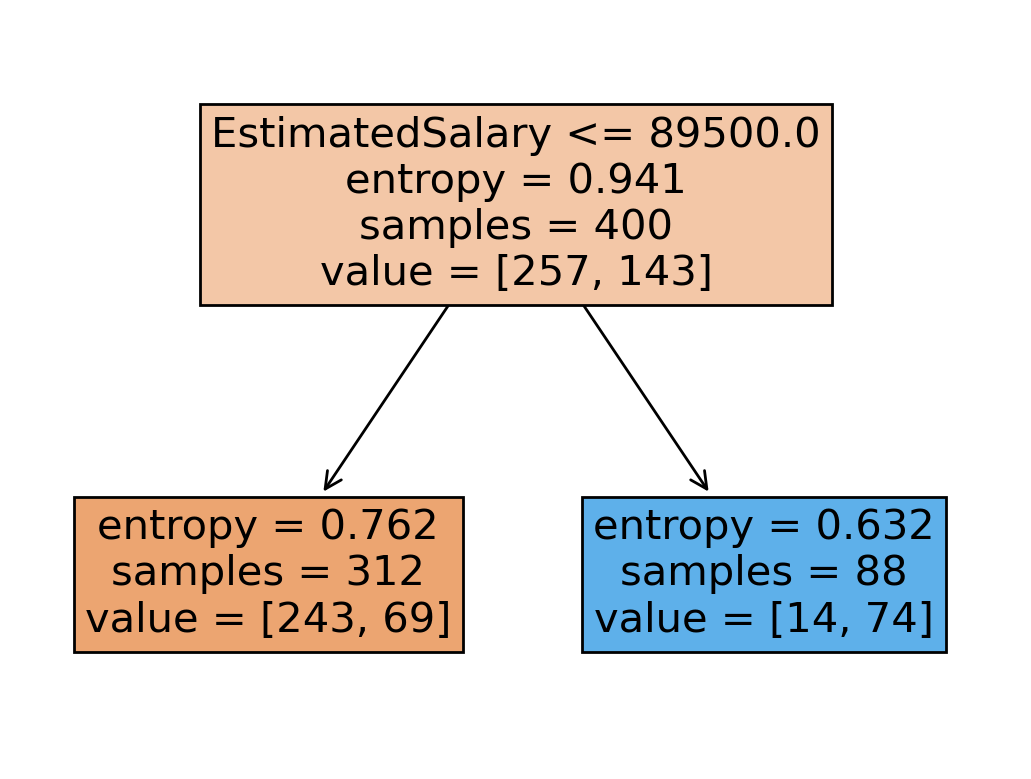

In [23]:
from sklearn.tree import plot_tree
plot_tree(
    clf, feature_names=["EstimatedSalary"], 
    filled=True, fontsize=15
)
plt.show()

#### A more complex tree...

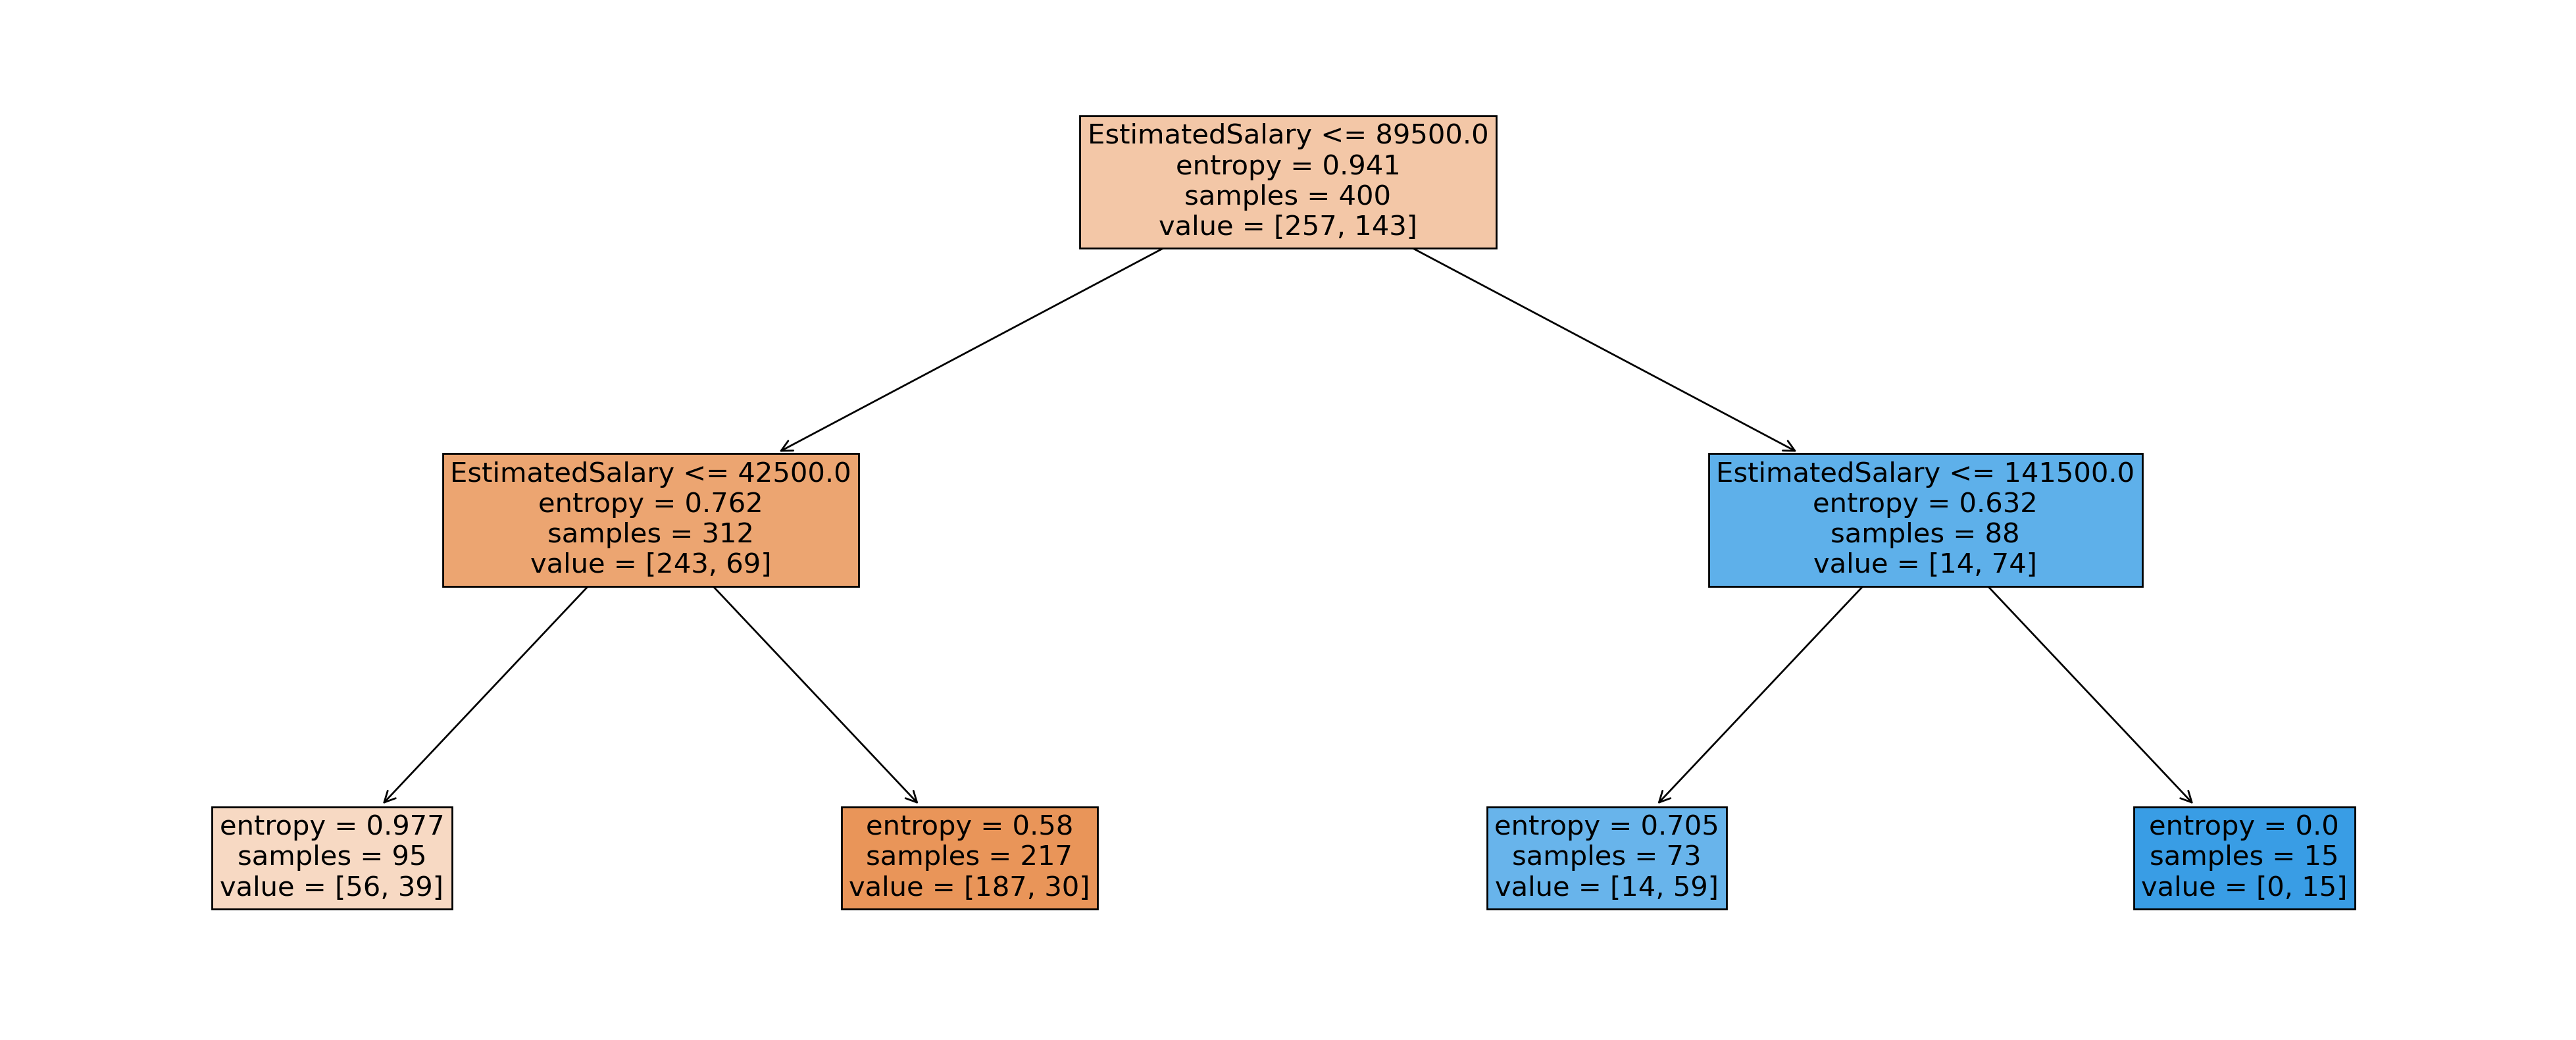

In [24]:
clf = DecisionTreeClassifier(max_depth = 2, criterion = "entropy")
clf.fit(X, y)
fig = plt.figure(figsize = (25,10))
plot_tree(
    clf, feature_names=["EstimatedSalary"], 
    filled=True, fontsize=15
)
plt.show()

#### Check-in

Try to fit different `DecisionTreeClassifier` models with the same `max_depth` but different values of `ccp_alpha`. What do you notice?

In [25]:
### Your code here

#### Using `ccp_alpha`

- In general, increasing `ccp_alpha` will simplify your tree.  
- Typically, this is something you'd want to tune using **cross-validation**.
   - Just like $\lambda$ in regularization!

### Getting predictions

- We can use `model.predict(X)` to generate *predictions*.  
- We can then compare those predictions to the actual values of `y`. 

In [26]:
### Get predictions
y_pred = clf.predict(X)
### Calculate accuracy
(y_pred == y).mean()

0.7925

### Using `DecisionTreeClassifier`: summary

- `DecisionTreeClassifier` is a useful class for **fitting decision trees**.
- A couple important hyper-parameters to consider: `max_depth` and `ccp_alpha`.
   - These will ultimately control the complexity and fit of the tree(s).  
- Of course, in practice you'd want to evaluate this using **cross-validation**!

## Trade-offs

- Decision trees have a number of **advantages**.  
   - Easy to explain, interpretable.  
   - *May* mirror how humans make decisions.  
   - Clear graphical display. 
- But also **disadvantage**.  
   - Prone to overfitting.  
   - Non-robust: small changes in data can lead to significant changes in final model.



### Decision trees for *regression*

- Although we're focusing on *classification*, decision trees can be used for **regression** too.  
- Instead of minimizing *entropy*, instead minimize $RSS$. 
- As with classification, split feature space into **regions**. 
  - $\hat{Y}$ is the average response value in a given region.

## Lecture wrap-up

- Decision trees are (relatively) simple, interpretable methods that can be applied to classification.  
- Basic intuition: find the *splits* in our variables that maximally separate classes.  
  - Can result in complexity, so requires *pruning*.  
- Easy to explain, but also tend to be non-robust.
- As we'll see next time, **ensemble methods** can sometimes address these disadvantages (though they are less interpretable).